In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import re
import numpy as np
import datetime
import string
import math
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/krishna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data

## Data Loading

In [2]:
# load in each dataset

calendar = pd.read_csv('data/calendar.csv', index_col = 'listing_id')
listings = pd.read_csv('data/listings.csv', index_col = 'id')
reviews = pd.read_csv('data/reviews.csv', index_col = 'listing_id')

/Users/krishna/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Data Cleaning

In [3]:

# convert string dates to datetime dates for time manipulation
calendar['date'] = pd.to_datetime(calendar.date)

# remove $ and , from prices and convert to float
calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True).astype(float)

# add day of week
calendar['DayOfWeek'] = calendar['date'].apply(lambda x: x.strftime('%a')) 

# Q1 Are there temporal patterns in bookings?

In [4]:
# subset data to only dates that are booked
booked = calendar[calendar.available == 'f']

Text(2017-03-15, 2100, 'Boston Marathon')

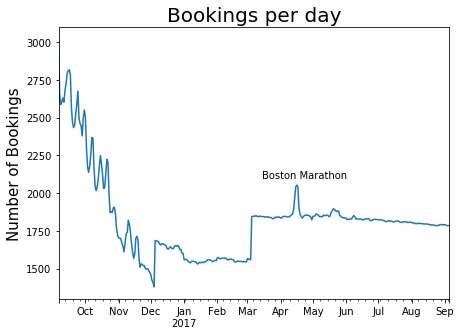

In [5]:
fig,ax = plt.subplots(figsize = (7,5))

# plot daily number of bookings
booked.groupby([pd.Grouper(freq='D',key = 'date')]).count()['DayOfWeek'].plot(ax = ax)
ax.set_title('Bookings per day', fontsize = 20)
ax.set_ylabel('Number of Bookings', fontsize = 15)
ax.set_xlabel('')

ax.annotate('Boston Marathon',xy = ('2017-03-15',2100))

### The number of bookings drastically decreased  until December 2017, level out for a few months, and then finalized around 1750 bookings per day for the rest of the year.  The spike in April 14-17 2017 was because of the Boston Marathon

Text(0.5, 1.0, 'Bookings by Day of Week')

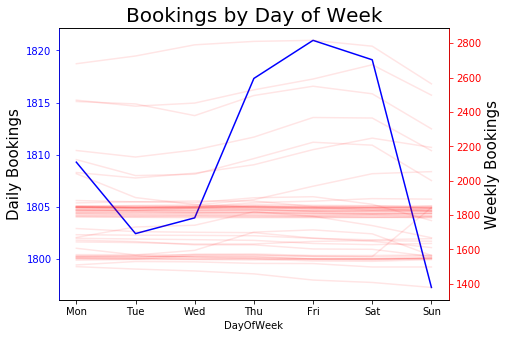

In [6]:
# order of days
new_index = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

# set index as the week of the booking
booked_week = booked.set_index(booked['date'].dt.to_period('W').apply(lambda r: r.start_time))
# group by week AND day of week
# get the number of the bookings per group
booked_week_groups = booked_week.groupby([booked_week.index,'DayOfWeek']).count()['available']
# filter data to remove first and last week (they are incomplete)
groups = booked_week_groups[(booked_week_groups.index.get_level_values(0) < '2017-09-04') & (booked_week_groups.index.get_level_values(0) > '2016-09-05')]

fig,ax = plt.subplots(figsize = (7,5))

# plot overall pattern of number of bookings by day of week
groups.groupby(level = 'DayOfWeek').mean().reindex(new_index).plot(ax = ax,c = 'b')

## plot pattern for individual weeks

# get list of all weeks
weeks = groups.index.get_level_values(0).unique()

# create a twin axis for the other side
ax2 = ax.twinx()

# plot each week
for week in weeks:
    groups[week].reindex(new_index).plot(ax = ax2, alpha = 0.1, c = 'r')
    
ax2.spines['right'].set_color('red')
ax2.spines['left'].set_color('blue')

ax2.tick_params(axis='y', colors='red')
ax.tick_params(axis='y', colors='blue')

ax.set_ylabel('Daily Bookings', fontsize = 15)
ax2.set_ylabel('Weekly Bookings', fontsize = 15)
ax.set_title('Bookings by Day of Week', fontsize = 20)


### As one would expect, most bookings occur Thursday, Friday, and Saturday; this is most likely due to vacationers.

# Q2 What are the variations in the prices changes? Is there a weekly pattern? 


In [7]:
# get vacancies
vacant = calendar[calendar.available == 't']

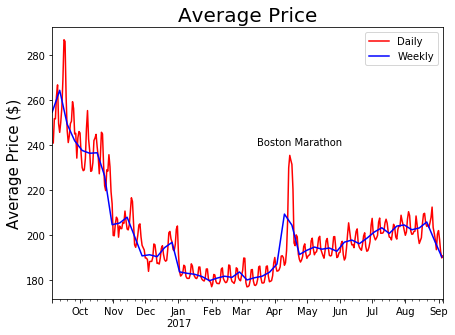

In [8]:
fig,ax = plt.subplots(figsize = (7,5))

# plot mean price daily and weekly
vacant[['date','price']].groupby([pd.Grouper(freq='D',key = 'date')]).mean().plot(ax = ax, c = 'r')
vacant[['date','price']].groupby([pd.Grouper(freq='W',key = 'date')]).mean().plot(ax = ax, c = 'b')

ax.annotate('Boston Marathon',xy = ('2017-03-15',240))

ax.set_title('Average Price', fontsize = 20)
ax.set_ylabel('Average Price ($)', fontsize = 15)
ax.set_xlabel('')
ax.legend(["Daily", "Weekly"]);

### Winter prices for Boston AirBnB are lower than spring/summer prices. This can be better confirmed with more years of data.  There also seems to be a daily pattern in the price. 

### The Boston Marathon also caused a significant pricing surge.

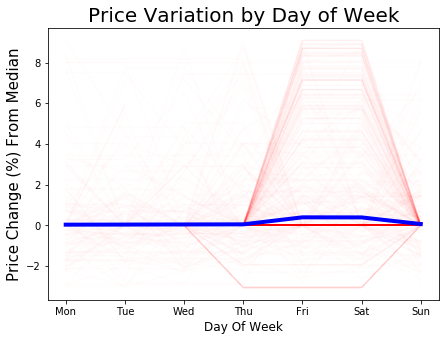

In [9]:
fig,ax = plt.subplots(figsize = (7,5))

# order of days
new_index = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

# calculate median price by listing and day of week (dow)
price_median = vacant.groupby([vacant.index,'DayOfWeek'])['price'].median().reset_index(level = 1)

## normalize the median price of dow by the median price of the listing: 100 * (price/mean price - 1)
numerator = vacant.groupby([vacant.index,'DayOfWeek'])['price'].median().reset_index(level = 1)['price']
denominator = vacant.groupby([vacant.index])['price'].median()
price_median['Normalized Price'] =  100 * (numerator/denominator - 1)

# calculate some quantiles as cutoffs (5% and 95%)
limits = price_median['Normalized Price'].quantile([0.05,0.5,0.95])

# remove extreme values defined by cutoffs
filtered_price_index = price_median[(price_median['Normalized Price'] > limits[0.95] ) | (price_median['Normalized Price'] < limits[0.05])].index
filtered_price_median_df = price_median[~price_median.index.isin(filtered_price_index)]

# plot average prices per day for all listings
filtered_price_median_df.groupby('DayOfWeek')['Normalized Price'].mean().reindex(new_index).plot(ax = ax, c = 'b',linewidth=4)

# list of all listings
listings_list = filtered_price_median_df.index.unique()

# plot average (mean) normalized price per day of week by day of week
for listing in listings_list:
    data_listing = filtered_price_median_df[filtered_price_median_df.index == listing]
    data_listing.groupby('DayOfWeek')['Normalized Price'].mean().reindex(new_index).plot(ax = ax,c='r',alpha = 0.01, zorder = -1)

ax.set_title('Price Variation by Day of Week', fontsize = 20);
ax.set_xlabel('Day Of Week', fontsize = 12);
ax.set_ylabel('Price Change (%) From Median', fontsize = 15);




### The data suggests that there is a small increase (1%) on the busier days. There are individual listings that have almost a 10% increase.

# Q3 What are words that do and don't describe the Boston neighborhoods?

In [10]:
# make new df of just the neighborhoods and their descriptions
neigborhood_df = listings[['neighbourhood_cleansed','neighborhood_overview']].dropna()


In [11]:
def preprocess_text(text):
    '''
    cleans text by lowercasing all words and removing numbers
    input: str
    output: str
    '''
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text

# calculate tfidf with a 
# minimum word count of 30 
# cleaned text
# removing common english stop words
tfidf_model = TfidfVectorizer(min_df = 20, preprocessor=preprocess_text, stop_words = 'english')
tfidf_scores = tfidf_model.fit_transform(neigborhood_df['neighborhood_overview'])

# convert scores to a df with listings as rows and words as columns
tfidf_df = pd.DataFrame(tfidf_scores.toarray(), columns=tfidf_model.get_feature_names(), index = neigborhood_df.index)

### I isolate important words by calculating the TF-IDF. This is better than word frequency because it prioritizes words that are unique to each group while deprioritizing words that are common among all groups.

In [12]:
# calculate correlation matrix
corr_matrix = tfidf_df.corr().abs()

# choose half of the matrix - upper half
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# isolate features with greater than 0.9 correlation
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

# drop those features in place
tfidf_df.drop(to_drop, axis=1, inplace = True)


In [13]:
# find amount of listings in each neighborhood
print(neigborhood_df.groupby('neighbourhood_cleansed').size().sort_values(ascending = False))

# only keep neighborhoods with enough data
columns_to_keep = ['Jamaica Plain', 'South End', 'Back Bay', 'Dorchester', 'Beacon Hill',
       'Allston', 'South Boston', 'Fenway']

# drop words in tfidf dictionary that are the neighborhood
# in two word neighborhoods, drop both words individualy 
words_to_drop = ['jamaica','south','end','bay',
           'dorchester','beacon','hill','allston','south','boston','fenway']

neighbourhood_cleansed
Jamaica Plain              246
South End                  225
Back Bay                   181
Fenway                     148
Allston                    146
Dorchester                 144
Beacon Hill                131
South Boston               114
Downtown                   108
Brighton                   105
Roxbury                     92
North End                   88
East Boston                 87
Mission Hill                58
Charlestown                 53
Chinatown                   46
Roslindale                  42
South Boston Waterfront     41
West End                    32
West Roxbury                24
Bay Village                 19
Hyde Park                   15
Mattapan                    14
Longwood Medical Area        6
Leather District             5
dtype: int64


In [14]:
# list of indices that are in the resulting neighborhoods
listing_indices = neigborhood_df[neigborhood_df['neighbourhood_cleansed'].isin(columns_to_keep)].index

# features (X): tfidf scores in the correct neighborhood subset and with the dropped words
X = tfidf_df[tfidf_df.index.isin(listing_indices)].drop(words_to_drop, axis = 1)
# predictor (y): neighborhood name
y = neigborhood_df['neighbourhood_cleansed'][listing_indices]

# initialize a multiple comparison logistic regression model comparing one vs the rest
clf = LogisticRegression()

# Cross Fold Validation: stratify the population to give equal classes with a test size of 30%
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3)

# calculate ROC AUC [0,1] 10 times for the test datasets from the cross fold validation
cross_val_score(clf, X, y, cv=10)

array([0.75373134, 0.79850746, 0.76119403, 0.73880597, 0.79104478,
       0.77443609, 0.78947368, 0.82706767, 0.7443609 , 0.78195489])

In [15]:
# initialize a new model and fit to the entire data
clf = LogisticRegression()
clf.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
# number of finalized features
num_features = clf.coef_.shape[1]

## create dataframe of neighborhood vs feature (words) with various metrics from the model
# create index of neighborhoods
feature_lists = [[x] * num_features for x in clf.classes_]
feature_lists_index = [feature for feature_list in feature_lists for feature in feature_list]

# get coefficients of the words in the logistic model for each neighborhood and flatten into one long df
flattened_coeffs = np.reshape(clf.coef_, (num_features * len(clf.classes_)))

# convert into df with coeffecients along with odds ratio
lr_coeffs = pd.DataFrame({"Feature":X.columns.tolist() * len(clf.classes_),"Coeff":flattened_coeffs, "Odds Ratio":np.e**flattened_coeffs}, index = feature_lists_index)


In [17]:
area_of_interest = 'Jamaica Plain'
word_amount = 5

# filter results to only areas of interest
area = lr_coeffs[lr_coeffs.index == area_of_interest].sort_values(['Coeff'], ascending = False)

top_bottom = pd.concat([area.head(word_amount),area.tail(word_amount)])
text = 'Location descriptions for AirBnBs in {} are\n\n'.format(area_of_interest)

for feature,ratio in zip(top_bottom['Feature'],top_bottom['Odds Ratio']):
    text += '{} more likely to contain \"{}\"\n'.format(np.round(ratio,2),feature)

text += '\nthan other areas.'
print(text)

Location descriptions for AirBnBs in Jamaica Plain are

40.72 more likely to contain "pond"
32.69 more likely to contain "jp"
31.48 more likely to contain "arboretum"
10.6 more likely to contain "green"
7.68 more likely to contain "arnold"
0.38 more likely to contain "beach"
0.38 more likely to contain "apartment"
0.34 more likely to contain "historic"
0.33 more likely to contain "river"
0.31 more likely to contain "charles"

than other areas.


### Words with odds ratios greater than 1 more uniquely describe the neighborhood while specifically not describing another. 

### Words with odds ratios less than 1 do not describe the neighborhood well.